In [2]:
import numpy, pandas

import matplotlib.pyplot as plt

In [6]:
with open('./data/reference/NC_000962.3_pncA.fasta','r') as INPUT:
    INPUT.readline()
    pncA_sequence = INPUT.readline()

In [7]:
aminoacids = 'FFLLSSSSYY!!CC!WLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG'
bases = ['t', 'c', 'a', 'g']
all_codons = numpy.array([a+b+c for a in bases for b in bases for c in bases])
codon_to_amino_acid = dict(zip(all_codons, aminoacids))


In [8]:
index = 1

maximum_amino_acids = []
amino_acid_position = []

for codon in [pncA_sequence[i:i+3] for i in range(0,len(pncA_sequence),3)]:
    
    aminoacid = codon_to_amino_acid[codon]
    mutations = []

    for pos in [0, 1, 2]:
        for i in bases:
            if codon[pos] != i:
                new_codon = codon[:pos] + i + codon[pos+1:]
                new_aminoacid = codon_to_amino_acid[new_codon]

                if new_aminoacid != aminoacid and new_aminoacid not in mutations and new_aminoacid!="!":
                    mutations.append(new_aminoacid)

    # print(index, len(mutations))

    maximum_amino_acids.append(len(mutations))
    amino_acid_position.append(index)
    
    index+=1

max_aa = pandas.DataFrame(maximum_amino_acids, index=amino_acid_position, columns=['MAX'])

In [9]:
DATASET = pandas.read_csv('data/ds-traintest-phen.csv')
DATASET[:3]

,MUTATION,CONSISTENT_PHENOTYPE
0,A102V,S
1,A134D,S
2,A134P,R


In [10]:
DATASET.reset_index(inplace=True)
def find_position(row):
    return int(row.MUTATION[1:-1])

DATASET['POSITION'] = DATASET.apply(find_position, axis=1)

In [11]:
total = pandas.crosstab(DATASET.POSITION, DATASET.CONSISTENT_PHENOTYPE)
total['TOTAL'] = total.R + total.S
total['frac_R'] = total['R'] / total['TOTAL']
total = total.join(max_aa)
total

,R,S,TOTAL,frac_R,MAX
POSITION,,,,,
1,2,1,3,0.666667,6
2,0,1,1,0.000000,5
3,1,2,3,0.333333,6
4,4,1,5,0.800000,5
5,5,1,6,0.833333,7
...,...,...,...,...,...
181,1,1,2,0.500000,6
182,1,1,2,0.500000,5
183,1,2,3,0.333333,6


In [12]:
xs=[0.5]
ys=[0]
yt=[0]

prev_idx=0
for idx,row in total.iterrows():
    if idx-prev_idx!=1:
        print(idx, prev_idx)
    if idx==151:
        xs.append(149.5)
        xs.append(150.5)
        ys.append(0)
        ys.append(0)
        yt.append(0)
        yt.append(0)
    prev_idx=idx
    xs.append(idx-0.5)
    xs.append(idx+0.5)
    ys.append(row.TOTAL)
    ys.append(row.TOTAL)
    yt.append(row.MAX)
    yt.append(row.MAX)

151 149


In [56]:
metal_binding_residues = [49,51,57,71]

active_site_residues = [8,13,19,68,96,133,134,137,138]

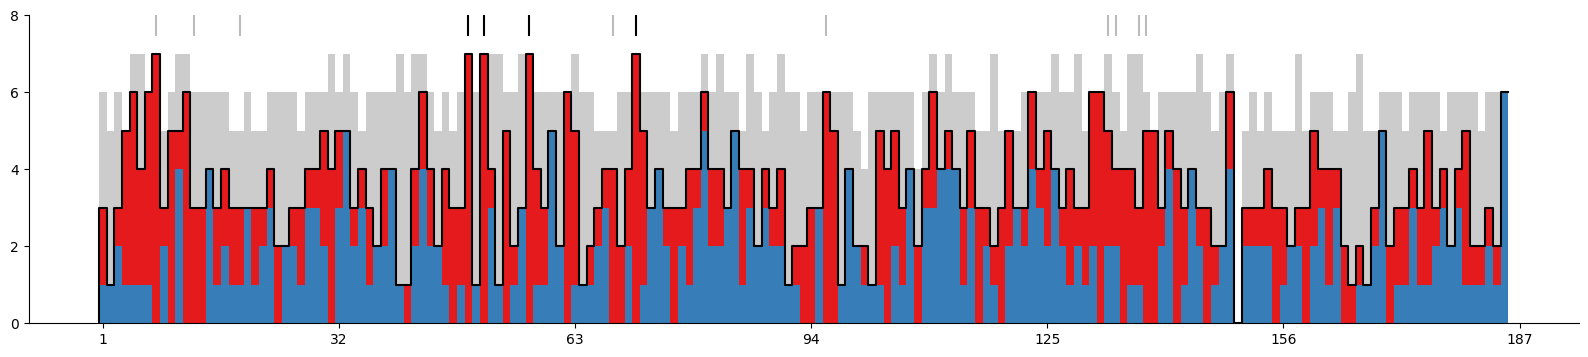

In [57]:
fig,axes=plt.subplots(1,1,figsize=(20,4))
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.set_ylim([0,7])
axes.set_yticks(range(0,10,2))
axes.set_xticks(range(1,188,31))
axes.bar(total.index, total.MAX, width=1, color='#cccccc')
axes.bar(total.index, total.S, width=1, color='#377eb8')
axes.bar(total.index, total.R, bottom=total.S, width=1, color='#e41a1c')
axes.plot(xs,ys, color='black')

# annotate the metal binding sites
for i in metal_binding_residues:
    axes.plot((i,i),(7.5,8.5), color='black')

for i in active_site_residues:
    axes.plot((i,i),(7.5,8.5), color='#bbbbbb')


# axes.plot(xs,yt, color='black')
fig.savefig('pdf/fig-1_hist-codon.pdf')

In [64]:
'resid ' + ' '.join(str(i) for i in metal_binding_residues)

'resid 49 51 57 71'

In [63]:
'resid ' + ' '.join(str(i) for i in active_site_residues)

'resid 8 13 19 68 96 133 134 137 138'

In [14]:
DST = pandas.read_csv('data/source-data/cryptic1-dst.csv')
MUTATIONS = pandas.read_csv('data/source-data/cryptic1-mutations.csv')

In [15]:
len(DST)

22842

In [17]:
variants_per_sample = MUTATIONS[['UNIQUEID','POSITION']].groupby('UNIQUEID').count()
variants_per_sample.POSITION.value_counts()

1    6622
2     228
3       1
Name: POSITION, dtype: int64

In [18]:
solos = variants_per_sample[variants_per_sample.POSITION==1].index
MUTATIONS.set_index('UNIQUEID', inplace=True)

SOLO_MUTATIONS = MUTATIONS.loc[solos]

def define_nonsense(row):
    if row.MUTATION[-1] == '!':
        return True
    else:
        return False

def define_missense(row):
    if not row.IS_NONSENSE and row.IS_NONSYNONYMOUS:
        return True
    else:
        return False


SOLO_MUTATIONS['IS_NONSENSE'] = SOLO_MUTATIONS.apply(define_nonsense, axis=1)
SOLO_MUTATIONS['IS_MISSENSE'] = SOLO_MUTATIONS.apply(define_missense, axis=1)
SOLO_MUTATIONS

,GENE,MUTATION,POSITION,AMINO_ACID_NUMBER,GENOME_INDEX,NUCLEOTIDE_NUMBER,REF,ALT,IS_SNP,IS_INDEL,...,IS_FILTER_PASS,ELEMENT_TYPE,MUTATION_TYPE,INDEL_LENGTH,INDEL_1,INDEL_2,SITEID,NUMBER_NUCLEOTIDE_CHANGES,IS_NONSENSE,IS_MISSENSE
UNIQUEID,,,,,,,,,,,,,,,,,,,,,
site.00.subj.1000347.lab.H111540004.iso.1,pncA,Q141P,141.0,141.0,NaN,NaN,cag,ccg,True,False,...,True,GENE,AAM,NaN,NaN,NaN,00,1,False,True
site.00.subj.1000595.lab.H123460044.iso.1,pncA,D12A,12.0,12.0,NaN,NaN,gac,gcc,True,False,...,True,GENE,AAM,NaN,NaN,NaN,00,1,False,True
site.00.subj.1004213.lab.H111060034.iso.1,pncA,392_indel,392.0,131.0,2288850.0,392.0,NaN,NaN,False,True,...,True,GENE,INDEL,2.0,392_ins,392_ins_2,00,0,False,False
site.00.subj.1004213.lab.H112000008.iso.1,pncA,392_indel,392.0,131.0,2288850.0,392.0,NaN,NaN,False,True,...,True,GENE,INDEL,2.0,392_ins,392_ins_2,00,0,False,False
site.00.subj.1004213.lab.H113100007.iso.1,pncA,392_indel,392.0,131.0,2288850.0,392.0,NaN,NaN,False,True,...,True,GENE,INDEL,2.0,392_ins,392_ins_2,00,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
site.ENA.subj.SAMN08892560.lab.1.iso.1,pncA,L4W,4.0,4.0,NaN,NaN,ttg,tgg,True,False,...,True,GENE,AAM,NaN,NaN,NaN,ENA,1,False,True
site.ENA.subj.SAMN08892561.lab.1.iso.1,pncA,S65S,65.0,65.0,NaN,NaN,tcc,tct,True,False,...,True,GENE,AAM,NaN,NaN,NaN,ENA,1,False,False
site.ENA.subj.SAMN08892562.lab.1.iso.1,pncA,S65S,65.0,65.0,NaN,NaN,tcc,tct,True,False,...,True,GENE,AAM,NaN,NaN,NaN,ENA,1,False,False


In [19]:
n_indel = len(SOLO_MUTATIONS[SOLO_MUTATIONS.IS_INDEL])
n_syn = len(SOLO_MUTATIONS[SOLO_MUTATIONS.IS_SYNONYMOUS])
n_promoter = len(SOLO_MUTATIONS[(SOLO_MUTATIONS.IS_SNP) & (SOLO_MUTATIONS.IN_PROMOTER)])
n_missense = len(SOLO_MUTATIONS[(SOLO_MUTATIONS.IS_SNP) & (SOLO_MUTATIONS.IS_MISSENSE)])
n_nonsense = len(SOLO_MUTATIONS[(SOLO_MUTATIONS.IS_SNP) & (SOLO_MUTATIONS.IS_NONSENSE)])
print(n_indel, n_syn, n_promoter, n_missense, n_nonsense)

401 3288 167 2691 75


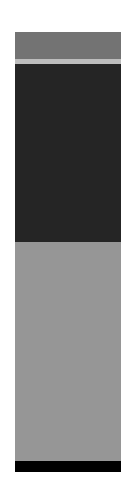

In [45]:
fig,axes=plt.subplots(1,1,figsize=(1.5,6))
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.axis('off')
axes.bar(1, n_promoter, width=1, color='#000000')
axes.bar(1, n_syn, bottom=n_promoter, width=1, color='#969696')
axes.bar(1, n_missense, bottom=n_promoter+n_syn, width=1, color='#252525')
axes.bar(1, n_nonsense, bottom=n_promoter+n_syn+n_missense, width=1, color='#bdbdbd')
axes.bar(1, n_indel, bottom=n_promoter+n_syn+n_missense+n_nonsense, width=1, color='#737373')
fig.savefig('pdf/fig-1_hist-variation.pdf')